In [2]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel("../Data/SPF_data.xlsx")
data.head()

,seg,Y,X1,X2,X3
0,59,49,4.344300,8076.666667,0.920747
1,58,44,9.025771,8076.666667,0.997145
2,57,35,9.401453,8076.666667,0.744566
3,56,1,0.685524,8076.666667,0.000000
4,55,5,1.494137,8076.666667,0.669283


In [5]:
#STEP1: fitting the Poisson regression model

expr = """Y ~ X1  + X2 + X3"""
y, X = dmatrices(expr, data, return_type='dataframe')

In [6]:
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   59
Model:                            GLM   Df Residuals:                       55
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -246.85
Date:                Mon, 29 Aug 2022   Deviance:                       256.43
Time:                        18:38:54   Pearson chi2:                     273.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4218      0.779      5.674      0.0

In [7]:
poisson_training_results.mu

array([12.71830932, 36.13459729, 38.97643128,  5.47407288,  6.69192303,
        8.78535575,  5.48651306,  6.59852074,  8.38989961,  9.98524284,
        6.71254683,  7.78458374, 25.94777247,  6.8893098 ,  8.1332193 ,
       18.83511683, 12.85633274, 31.68268253, 44.91925185, 11.00146828,
       11.63153292, 28.37975061, 28.40002064, 25.15942636,  7.98148665,
       10.64464069,  9.21098932,  9.90371576,  6.91506913,  7.85356889,
        8.72912333, 10.33046171,  8.45728685,  8.35933126,  9.94157857,
        7.43472519,  8.46645925,  8.45384905,  9.19494825,  9.39030579,
       14.83139332, 23.07613469, 16.76158833, 38.33599515,  9.01503771,
        7.22762013, 29.56115627,  8.35845593, 20.68745882,  8.11414041,
        9.55496081, 32.68986756, 11.80435773,  7.39749738, 14.39911253,
        9.83078711, 14.71237973, 14.1535599 , 22.64707611])

In [8]:
#STEP 2: The determination of α

import statsmodels.formula.api as smf

In [9]:
data['Y_LAMBDA'] = poisson_training_results.mu

In [10]:
data['AUX_OLS_DEP'] = data.apply(lambda x: ((x['Y'] - x['Y_LAMBDA'])**2 - x['Y_LAMBDA']) / x['Y_LAMBDA'], axis=1)

In [11]:
ols_expr = """AUX_OLS_DEP ~ Y_LAMBDA - 1"""

In [12]:
aux_olsr_results = smf.ols(ols_expr, data).fit()

In [13]:
print(aux_olsr_results.params)

Y_LAMBDA    0.135324
dtype: float64


In [14]:
aux_olsr_results.tvalues

Y_LAMBDA    1.310507
dtype: float64

In [15]:
print("Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=59 is 2.391229")
print("which is not comfortably less than the t-statistic of alpha (1.404661)")
print("So α=0.133967 is NOT statistically significant")
print("Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.")

Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=59 is 2.391229
which is not comfortably less than the t-statistic of alpha (1.404661)
So α=0.133967 is NOT statistically significant
Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.


In [16]:
#STEP 3: Train the NB2 on the data using the alpha found in the previous step

nb2_training_results = sm.GLM(y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [17]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   59
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -202.42
Date:                Mon, 29 Aug 2022   Deviance:                       110.89
Time:                        18:39:37   Pearson chi2:                     111.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5497      1.455      3.127      0.0

In [18]:
#STEP 4:  Make some predictions

nb2_predictions = nb2_training_results.get_prediction(X)

In [19]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

         mean   mean_se  mean_ci_lower  mean_ci_upper
0   12.614459  1.472207      10.035216      15.856618
1   38.909811  6.430906      28.143291      53.795179
2   42.230206  6.869784      30.701124      58.088761
3    5.084571  0.823894       3.701070       6.985241
4    6.311249  0.834267       4.870767       8.177740
5    8.464667  1.012186       6.696149      10.700268
6    5.097037  0.825114       3.711285       7.000214
7    6.216102  0.826536       4.790011       8.066772
8    8.053922  0.982413       6.341300      10.229078
9    9.719394  1.117032       7.759115      12.174922
10   6.335910  0.943007       4.732821       8.481992
11   7.431140  0.936317       5.805034       9.512751
12  27.232231  3.569843      21.062026      35.210021
13   6.516084  0.959795       4.882113       8.696920
14   7.791047  0.970281       6.103640       9.944953
15  19.272762  2.269638      15.300409      24.276434
16  12.767429  1.422423      10.262917      15.883129
17  33.776392  4.876160     

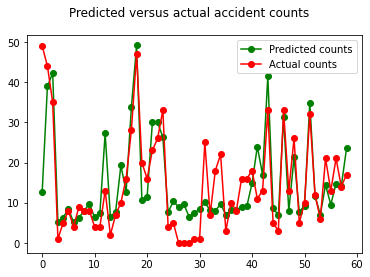

In [20]:
# Plotting Residuals
predicted_counts=predictions_summary_frame['mean']
actual_counts = y['Y']
fig = plt.figure()
fig.suptitle('Predicted versus actual accident counts')
predicted, = plt.plot(X.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [21]:
#STEP 5: Measuring the goodness-of-fit of the NB2 model

#Log-Likelihood: Likelihood-ratio (LR) test - negative two times the difference in the fitted log-likelihoods of the two models
LR = 2*(245.95-202.20)
print("LR test value =", LR)
print("χ2(1) = 6.635") # critical value of χ2(1) at the 1% significance level

LR test value = 87.5
χ2(1) = 6.635


In [22]:
#The Deviance and Pearson chi-squared statistics
NB_Deviance = 110.79
NB_Pearson_chi2 = 108

Chi_Squared_0_05 = 77.931
print("Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=59")
print("We might be able to do better!!")

Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=59
We might be able to do better!!
